In [1]:

import sys
sys.path.append('..')  # Add parent directory to path

from src.bias_detection.detector import BiasDetector
from src.bias_detection.simple_detector import SimpleBiasDetector
import pandas as pd

# Load the data we saved earlier
data = pd.read_csv('../data/processed/adult_with_labels.csv')
print(f"Loaded dataset with {len(data):,} samples")
print(f"Columns: {list(data.columns)}")


Loaded dataset with 48,842 samples
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income', 'high_income', 'is_female_high_income']


In [11]:
# Using the detailed BiasDetector
print("DETAILED BIAS DETECTION")
print("=" * 50)

# Initialize detector
detector = BiasDetector(verbose=True)

# Separate features and target
X = data.drop(columns=['income', 'high_income', 'is_female_high_income'])
y = data['income']

# Run bias detection
metrics = detector.detect_bias(
    X=X,
    y=y,
    protected_attribute='sex',
    positive_label='>50K'
)

DETAILED BIAS DETECTION
Starting bias detection analysis...
Protected attribute: sex
Positive outcome label: >50K
--------------------------------------------------

Group 'Male':
  Size: 32,650 (66.8%)
  Positive outcomes: 6,662
  Positive rate: 0.204

Group 'Female':
  Size: 16,192 (33.2%)
  Positive outcomes: 1,179
  Positive rate: 0.073

BIAS DETECTION RESULTS

Disparate Impact: 0.357
  Interpretation: Severe bias detected
  Legal threshold (80% rule): FAIL

Statistical Parity Difference: -0.131
  Interpretation: 13.1% difference in positive outcome rates

Group Analysis:
  Male: 20.4% positive rate (n=32,650)
  Female: 7.3% positive rate (n=16,192)



Generating visualizations...

Visualization saved to: ../results/figures/bias_analysis.png


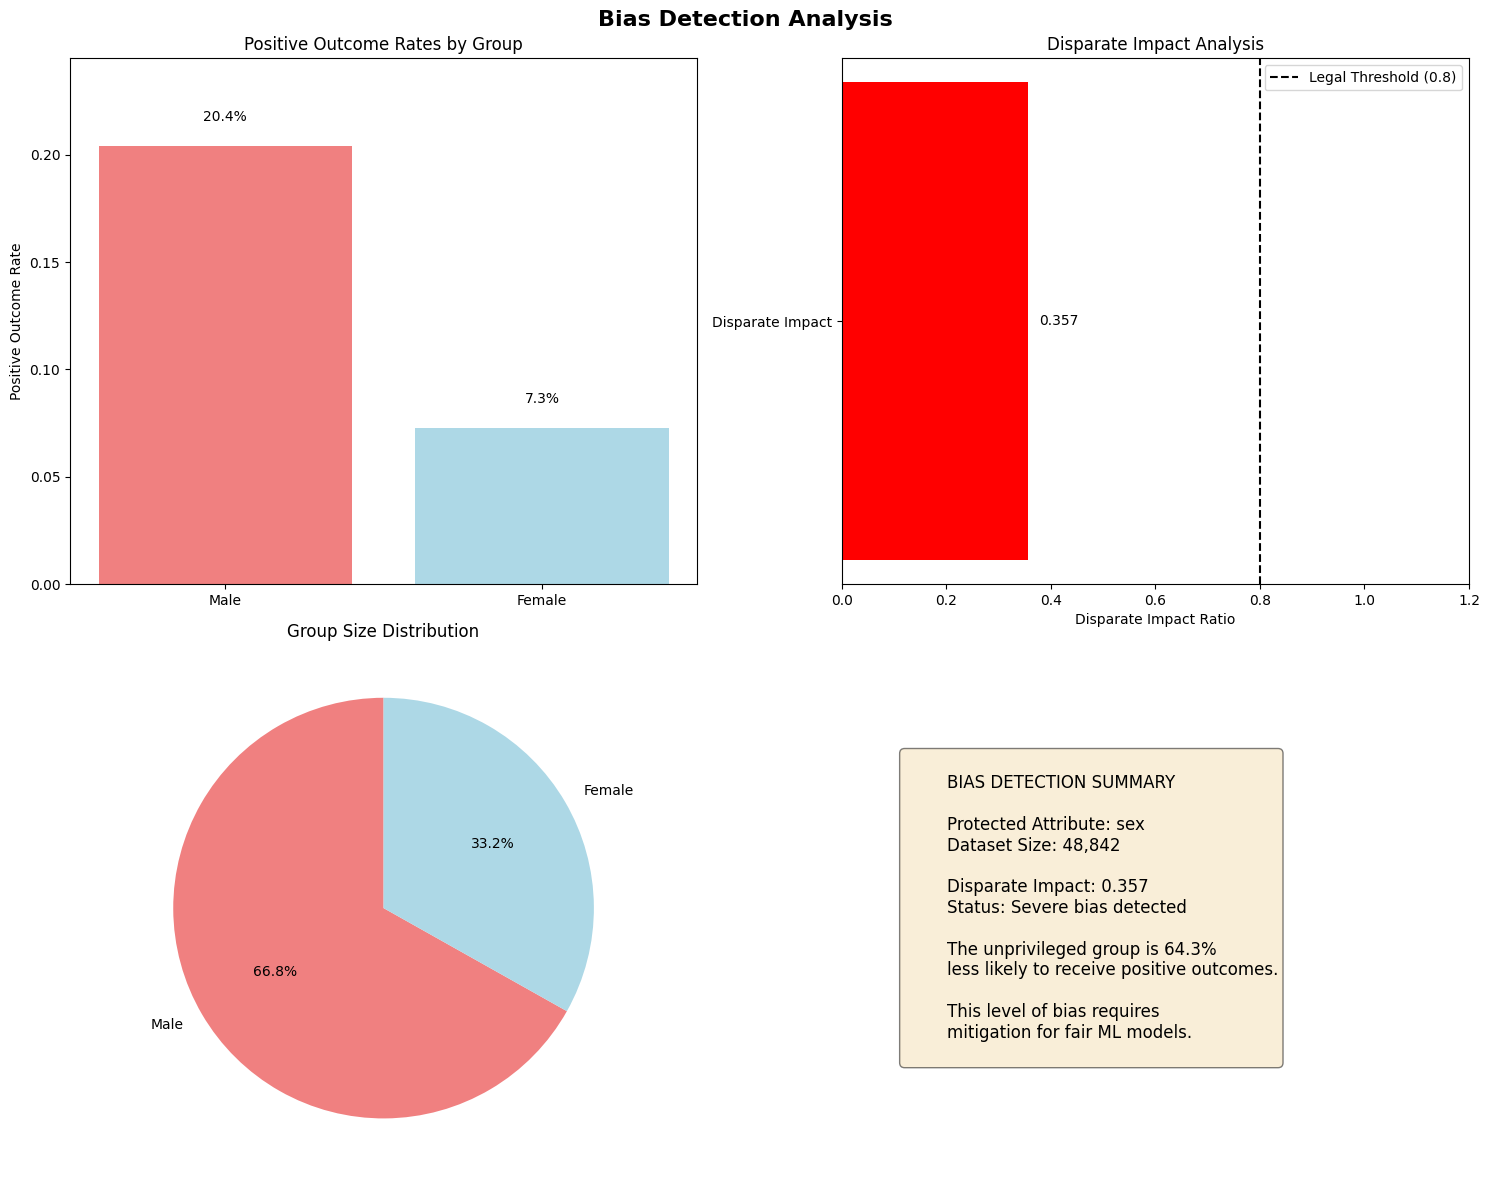

In [5]:
# Visualize the results
print("\nGenerating visualizations...")
detector.visualize_bias(save_path='../results/figures/bias_analysis.png')

In [7]:
# Generating a formal report
report = detector.generate_report()
print("\nFORMAL REPORT:")
print(report)

# Save the report
with open('../results/reports/bias_detection_report.txt', 'w') as f:
    f.write(report)
print("\nReport saved to: results/reports/bias_detection_report.txt")


FORMAL REPORT:

BIAS DETECTION REPORT

Dataset Information:
- Total Samples: 48,842
- Protected Attribute: sex

Group Distribution:
- Male: 32,650 (66.8%)
- Female: 16,192 (33.2%)

Bias Metrics:
1. Disparate Impact: 0.357
   - Legal Threshold (0.8): FAIL
   - Interpretation: Severe bias detected

2. Statistical Parity Difference: -0.131
   - Ideal Value: 0.000
   - Current Gap: 13.1%

3. Group Positive Rates:
   - Male: 20.4%
   - Female: 7.3%

Recommendations:
- Significant bias detected. Consider applying bias mitigation techniques.
- Recommended approach: Fairness-aware synthetic data generation (SMOTE).
- Target: Increase disparate impact to at least 0.8.

Note: This analysis assumes the dataset is representative of the population.
Bias in data collection or sampling may not be detected by these metrics.


Report saved to: results/reports/bias_detection_report.txt


In [8]:
# Using the simple interface
print("\n\nSIMPLE BIAS DETECTION")
print("=" * 50)

# Initialize simple detector
simple_detector = SimpleBiasDetector()

# Check for gender bias with minimal configuration
result = simple_detector.check_gender_bias(
    data=data,
    target_column='income'
    # Note: gender_column and positive_outcome are auto-detected!
)

# Print summary
simple_detector.print_summary()



SIMPLE BIAS DETECTION

🔍 GENDER BIAS ANALYSIS SUMMARY
Bias Status: ⚠️  BIASED
Severity: Severe bias detected
Disparate Impact: 0.357

📋 Recommendation:
   Severe bias detected. Immediate action required. Consider fairness-aware resampling and review data collection process.


In [9]:
# Understanding the metrics
print("\n\nUNDERSTANDING THE METRICS")
print("=" * 50)

print("""
1. DISPARATE IMPACT (DI)
   - Formula: P(Y=1|Female) / P(Y=1|Male)
   - Legal threshold: 0.8 (80% rule)
   - Your value: {:.3f}
   - Meaning: Women are {:.1f}% as likely as men to earn >50K

2. STATISTICAL PARITY DIFFERENCE (SPD)
   - Formula: P(Y=1|Female) - P(Y=1|Male)
   - Ideal value: 0.0
   - Your value: {:.3f}
   - Meaning: {:.1f}% fewer women earn >50K compared to men

3. BIAS SEVERITY
   - Based on disparate impact ranges
   - Your level: {}
   - Action needed: {}
""".format(
    metrics.disparate_impact,
    metrics.disparate_impact * 100,
    metrics.statistical_parity_difference,
    abs(metrics.statistical_parity_difference) * 100,
    metrics.get_bias_severity(),
    "Yes" if metrics.is_biased() else "No"
))



UNDERSTANDING THE METRICS

1. DISPARATE IMPACT (DI)
   - Formula: P(Y=1|Female) / P(Y=1|Male)
   - Legal threshold: 0.8 (80% rule)
   - Your value: 0.357
   - Meaning: Women are 35.7% as likely as men to earn >50K

2. STATISTICAL PARITY DIFFERENCE (SPD)
   - Formula: P(Y=1|Female) - P(Y=1|Male)
   - Ideal value: 0.0
   - Your value: -0.131
   - Meaning: 13.1% fewer women earn >50K compared to men

3. BIAS SEVERITY
   - Based on disparate impact ranges
   - Your level: Severe bias detected
   - Action needed: Yes



In [10]:
# Checking bias in different subgroups
print("\n\nSUBGROUP ANALYSIS")
print("=" * 50)

# Let's check bias within different education levels
education_levels = data['education'].value_counts().head(5).index

for edu_level in education_levels:
    subset = data[data['education'] == edu_level]
    
    if len(subset[subset['sex'] == 'Female']) > 10:  # Ensure enough samples
        print(f"\nEducation level: {edu_level}")
        result = simple_detector.check_gender_bias(
            data=subset,
            target_column='income'
        )
        print(f"  Disparate Impact: {result['disparate_impact']}")
        print(f"  Bias Level: {result['bias_level']}")



SUBGROUP ANALYSIS

Education level: HS-grad
  Disparate Impact: 0.327
  Bias Level: Severe bias detected

Education level: Some-college
  Disparate Impact: 0.265
  Bias Level: Severe bias detected

Education level: Bachelors
  Disparate Impact: 0.403
  Bias Level: Significant bias detected

Education level: Masters
  Disparate Impact: 0.492
  Bias Level: Significant bias detected

Education level: Assoc-voc
  Disparate Impact: 0.412
  Bias Level: Significant bias detected
